# Data Clean and Feature Engineering
1. `train_0N.csv` and `test_0N.csv` came from Andrew's notebook after remove all the `NaN` in the files.
2. The following processes were performed:
    - Remove irrelevant cols
    - Remove low variance vars
    - Merge high colinearity vars
    - Log transfer on all high scewness items
    - Consistent ordinal mapping with know ordinal cols
    - Generate numerical data to some nominal cols
    - Dummy replacement on pure nominal cols
    - Feature engineering suspended

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import feature_selection
import matplotlib.pyplot as plt
import seaborn as sns

Skewness is:      1.883
Kurtosis is:      6.536
Skewness is:      0.121
Kurtosis is:      0.810


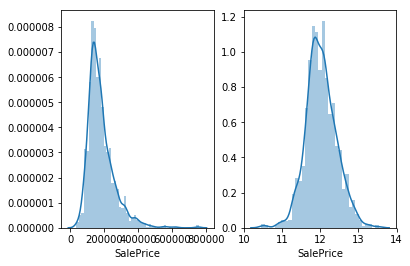

In [2]:
# import NA free data
train = pd.read_csv('train_0N.csv')
test = pd.read_csv('test_0N.csv')
# small fix
mask = test.MSZoning == 'C (all)'
test.loc[mask, 'MSZoning'] = 'C'

# plot frame
plt.figure()
# plot see the sale price trend
plt.subplot(1, 2, 1)
sns.distplot(train['SalePrice'])
# we can see a positive skewness
print("Skewness is: {0:10.3f}\nKurtosis is: {1:10.3f}"
      .format(train['SalePrice'].skew(), 
              train['SalePrice'].kurt()))
# log the skwed data
train["SalePrice"] = np.log1p(train["SalePrice"])
# plot see the sale price trend
plt.subplot(1, 2, 2)
sns.distplot(train['SalePrice'])
# we can see a positive skewness
print("Skewness is: {0:10.3f}\nKurtosis is: {1:10.3f}"
      .format(train['SalePrice'].skew(), 
              train['SalePrice'].kurt()))

# This log transfer will be performed later on all numberic cols with large skewness.
# The purpose is to increase linearity
# prediction must be revesed back!!!

# To reverse back
def logToNormal(logValue):
    pass
    # develop later

In [3]:
# drop irrelevant cols
train.drop(['Unnamed: 0', 'Id'], axis = 1, inplace = True)
test.drop(['Unnamed: 0', 'Id'], axis = 1, inplace = True)

# Refer to Shu's code and remove low variance cols
toBeRemLowVar = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 
                 'LowQualFinSF', 'X3SsnPorch', 'PoolArea', 'PoolQC', 'MiscVal']

# func to remove list
def removeDueShuCode(df, toBeRemLowVar):
    for col in toBeRemLowVar:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    else:
        pass
# Remove
removeDueShuCode(train, toBeRemLowVar)
removeDueShuCode(test, toBeRemLowVar)

# check if any dataframe contains NA, if does return the columns. 
def checkNull(df):
    if not isinstance(df, pd.DataFrame):
        return('No dataframe find!')
    if df.isnull().sum().sum() != 0:
        byCol = df.isnull().sum()
        return(byCol[byCol!=0])
    else:
        return ('The dataframe is NA free. Contains {0} rows with {1} attributes'.format(df.shape[0], df.shape[1]))
    
    
# check train & test
# If any data is not NA free: revise imputation step before proceed any further. 
print('Train: {0}\nTest: {1}'.format(checkNull(train),checkNull(test)))


# check num and cat col counts
def colTypeCount(df):
    if not isinstance(df, pd.DataFrame):
        return('No dataframe find!')
    lenNum = df.select_dtypes(include=[np.number]).shape[1]
    return ('has {0} num cols, and {1} cat cols'.format(lenNum, df.shape[1] - lenNum))

# check train & test
print('Train: {0}\nTest: {1}'.format(colTypeCount(train),colTypeCount(test)))


Train: The dataframe is NA free. Contains 1460 rows with 72 attributes
Test: The dataframe is NA free. Contains 1459 rows with 71 attributes
Train: has 34 num cols, and 38 cat cols
Test: has 33 num cols, and 38 cat cols


In [4]:
# drop columns with variance lower than threshold
def lowVarCol(df, threshold = 1.0):
    numCols = df.select_dtypes(include=[np.number])
    var = numCols.var()
    lowVar = var[var<=threshold]
    return var, lowVar

# analyze train 
varStats, lowVar = lowVarCol(train, 1.0)

print (lowVar)
# we can see most var are above 1.0
#print (varStats)


BsmtFullBath    0.269268
BsmtHalfBath    0.057003
FullBath        0.303508
HalfBath        0.252894
Bedroom         0.665494
Kitchen         0.048549
Fireplaces      0.415595
GarageCars      0.558480
SalePrice       0.159560
dtype: float64


In [5]:
# Merge BsmtBath = BsmtFullBath + BsmtHalfBath*0.5 
# Merge Bath = FullBath + HalfBath*0.5
# shape after merge 1460, 78 (from 80)
def mergeBathAndBaseBath(df):
    if {'BsmtBath', 'Bath'}.issubset(df.columns):
        pass
    else:
        df['BsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5
        df.drop(['BsmtFullBath','BsmtHalfBath'], axis=1, inplace=True)
        df['Bath'] = df['FullBath'] + df['HalfBath'] * 0.5
        df.drop(['FullBath','HalfBath'], axis=1, inplace=True)

mergeBathAndBaseBath(train)
mergeBathAndBaseBath(test)

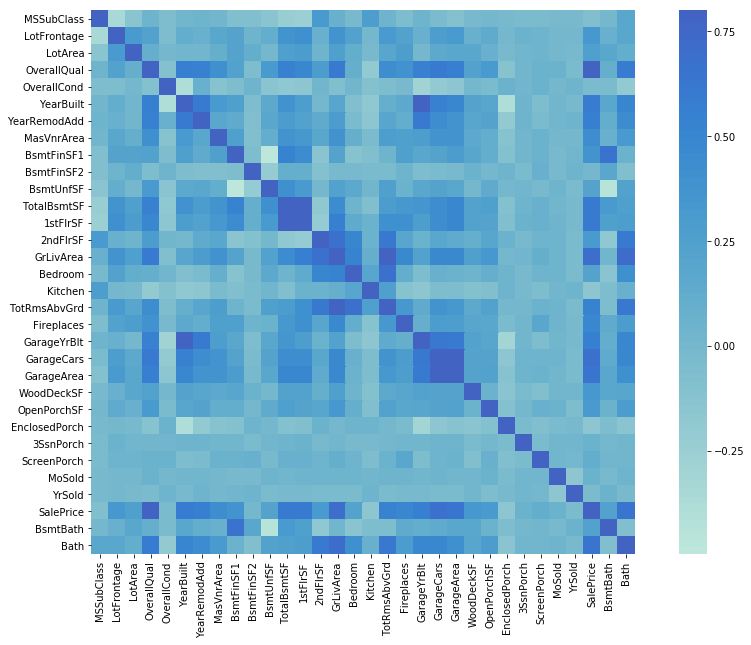

In [6]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corrmat, vmax=.8, square=True, center=2)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [7]:
print(corrmat['1stFlrSF']['TotalBsmtSF'])
print(corrmat['GarageArea']['GarageCars'])
# Refer collinear vars
toBeRemCollinear = ['1stFlrSF', 'GarageCars']
def removeCollinear(df, toBeRemCollinear):
    for col in toBeRemCollinear:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
        else:
            pass
# Remove
removeCollinear(train, toBeRemCollinear)
removeCollinear(test, toBeRemCollinear)

0.8195299750050355
0.8824754142814603


## Start on categorical

In [8]:
# Now works on the categorical cols
def colByType(df): 
    totalCol = list(df.columns)
    numericalCol = list(df.describe().columns)
    categoricalCol = [x for x in totalCol if x not in numericalCol]
    return numericalCol, categoricalCol

numTrain, catTrain = colByType(train)
numTest, catTest = colByType(test)

# start point
print('Before change, we have {0} cat cols for train/test'.format(len(catTrain)))

# general check
# for col in catTrain:
#     print (col, train[col].unique())

Before change, we have 38 cat cols for train/test


In [9]:
# Upon read data_description.txt, the orinal cols are

ordCols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
          'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
          'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence', 
          'CentralAir']
# Testing
# for i in ordCols:
#      print (i, train[i].unique())

codeToLevelDict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
             "Mn": 2, "Av": 3, 
             "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
             "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8,
             "RFn": 2, "Fin": 3,
             "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
             "N": 0, "Y": 1,
            }


def codeToLevel(df, ordCols, codeToLevelDict):
    for col in ordCols:
        if np.issubdtype(df[col].dtype, np.number):
            pass
        else:
            df[col] = df[col].map(codeToLevelDict).astype(int)
            
# Convert
codeToLevel(train, ordCols, codeToLevelDict)
codeToLevel(test, ordCols, codeToLevelDict)


# Report
numTrainNew, catTrainNew = colByType(train)
numTestNew, catTestNew = colByType(test)
print('{0} cat cols in train/test,\n{1} are ordinal data, \nafter convert,\
now train/test has {2} cate cols, \nwhich are nominial cols.'.format(len(catTrain), len(ordCols), len(catTestNew)))



38 cat cols in train/test,
15 are ordinal data, 
after convert,now train/test has 23 cate cols, 
which are nominial cols.


In [10]:
# general check
# for col in catTestNew:
#     print (col, train[col].unique())

In [11]:
# Neighborhood
neighborhoodPrice = train["SalePrice"].groupby(train["Neighborhood"]).median().sort_values()
neighborhoodMap = dict(zip(list(neighborhoodPrice.index), list(neighborhoodPrice)))
# modified code to level
def codeToLevelFloat(df, ordCols, codeToLevelDict):
    for col in ordCols:
        if np.issubdtype(df[col].dtype, np.number):
            pass
        else:
            df[col] = df[col].map(codeToLevelDict).astype(float)
            
# Convert
codeToLevelFloat(train, ordCols = ["Neighborhood"], codeToLevelDict = neighborhoodMap)
codeToLevelFloat(test, ordCols = ["Neighborhood"], codeToLevelDict = neighborhoodMap)



In [12]:
numTrainNew, catTrainNew = colByType(train)
numTestNew, catTestNew = colByType(test)
for col in catTestNew:
    print (col, train[col].unique())
len(catTestNew)

MSZoning ['RL' 'RM' 'C' 'FV' 'RH']
Alley ['No' 'Grvl' 'Pave']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
Exterior2nd ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn' 'No']
Foundation ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']
BsmtExposure ['No' 'Gd' 'Mn' 'Av']
Heating ['GasA' 'GasW' 'Grav

22

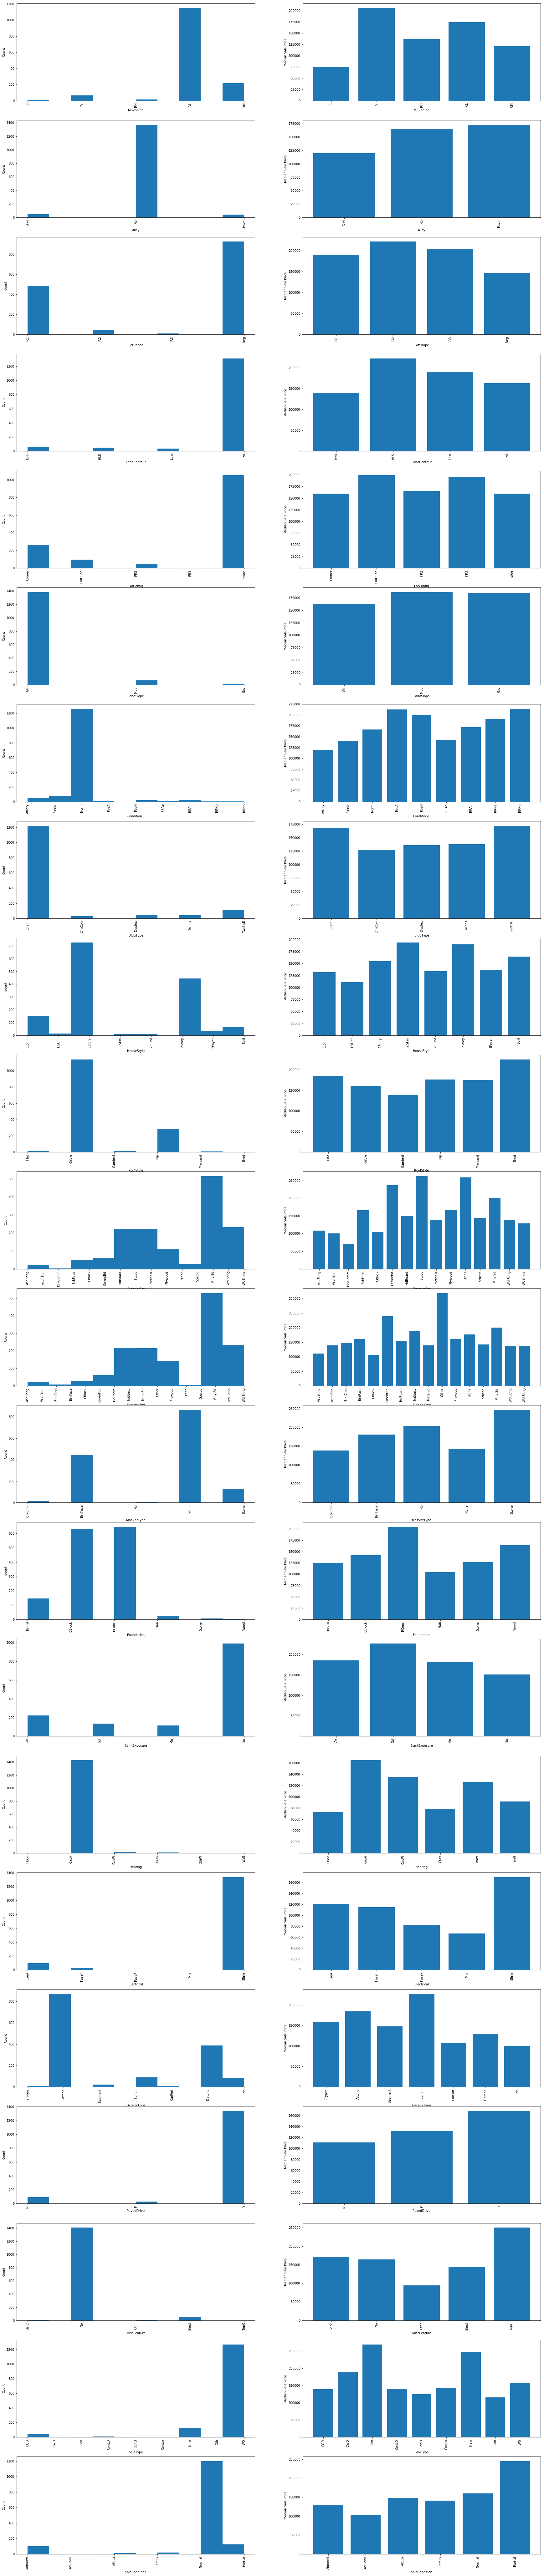

In [13]:
# analyze rest 22 cols by distribution and impact on sale price.
graphRows = len(catTestNew)
plt.figure(figsize = (30,150))
i = 1
trainRaw = pd.read_csv('train_0N.csv')
for col in catTrainNew:
    
    plt.subplot(graphRows, 2, i)
    i+=1
    plt.hist(train[col])
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(rotation=90)
    
    plt.subplot(graphRows, 2, i)
    i+=1
    #plt.hist(train['MSZoning'])
    conditionPivot = trainRaw.pivot_table(index=col, values='SalePrice', aggfunc=np.median)
    plt.bar(conditionPivot.index, conditionPivot['SalePrice'])
    plt.ylabel('Median Sale Price')
    plt.xlabel(col)
    plt.xticks(rotation=90)


In [24]:
for col in list(catTrainNew):
    print(np.unique(test[col]))

['C' 'FV' 'RH' 'RL' 'RM']
['Grvl' 'No' 'Pave']
['IR1' 'IR2' 'IR3' 'Reg']
['Bnk' 'HLS' 'Low' 'Lvl']
['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
['Gtl' 'Mod' 'Sev']
['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNe' 'RRNn']
['1Fam' '2fmCon' 'Duplex' 'Twnhs' 'TwnhsE']
['1.5Fin' '1.5Unf' '1Story' '2.5Unf' '2Story' 'SFoyer' 'SLvl']
['Flat' 'Gable' 'Gambrel' 'Hip' 'Mansard' 'Shed']
['AsbShng' 'AsphShn' 'BrkComm' 'BrkFace' 'CBlock' 'CemntBd' 'HdBoard'
 'MetalSd' 'Plywood' 'Stucco' 'VinylSd' 'Wd Sdng' 'WdShing']
['AsbShng' 'AsphShn' 'Brk Cmn' 'BrkFace' 'CBlock' 'CmentBd' 'HdBoard'
 'ImStucc' 'MetalSd' 'Plywood' 'Stone' 'Stucco' 'VinylSd' 'Wd Sdng'
 'Wd Shng']
['BrkCmn' 'BrkFace' 'No' 'None' 'Stone']
['BrkTil' 'CBlock' 'PConc' 'Slab' 'Stone' 'Wood']
['Av' 'Gd' 'Mn' 'No']
['GasA' 'GasW' 'Grav' 'Wall']
['FuseA' 'FuseF' 'FuseP' 'SBrkr']
['2Types' 'Attchd' 'Basment' 'BuiltIn' 'CarPort' 'Detchd' 'No']
['N' 'P' 'Y']
['Gar2' 'No' 'Othr' 'Shed']
['COD' 'CWD' 'Con' 'ConLD' 'ConLI' 'ConLw' 'New' '

In [26]:
# Construct nominal to level dict from graph above.
nomiToLevelDict = [MSZoningDict = dict(zip(np.unique(test['MSZoning']),[1,3,2,3,2])),
AlleyDict = dict(zip(np.unique(test['Alley']),[1,2,2])),
LotShapeDict = dict(zip(np.unique(test['LotShape']),[2,2,2,1])),
LandContourDict = dict(zip(np.unique(test['LandContour']),[1,4,3,2])),
LotConfigDict = dict(zip(np.unique(test['LotConfig']),[1,2,1,2,1])),
LandSlopeDict = dict(zip(np.unique(test['LandSlope']),[1,2,2])),
Condition1Dict = dict(zip(np.unique(test['Condition1']),[1,2,3,4,4,2,3,4,4])),
BldgTypeDict = dict(zip(np.unique(test['BldgType']),[2,1,1,1,2])),
HouseStyleDict = dict(zip(np.unique(test['HouseStyle']),[2,1,3,4,2,4,2,3])),
RoofStyleDict = dict(zip(np.unique(test['RoofStyle']),[3,2,1,3,3,4])),
Exterior1stDict = dict(zip(np.unique(test['Exterior1st']),[2,2,1,3,2,4,3,4,3,3,4,3,4,3,3])),
Exterior2ndDict = dict(zip(np.unique(test['Exterior2nd']),[1,2,2,2,1,3,2,2,2,4,2,2,2,2,2,2])),
MasVnrTypeDict = dict(zip(np.unique(test['MasVnrType']),[1,2,2,1,3])),
FoundationDict = dict(zip(np.unique(test['Foundation']),[1,1,3,1,1,2])),
BsmtExposureDict = dict(zip(np.unique(test['BsmtExposure']),[2,3,2,1])),
HeatingDict = dict(zip(np.unique(test['Heating']),[1,3,2,1,2,1])),
ElectricalDict = dict(zip(np.unique(test['Electrical']),[2,2,1,1,3])),
GarageTypeDict = dict(zip(np.unique(test['GarageType']),[2,2,2,3,1,1,1])),
PavedDriveDict = dict(zip(np.unique(test['PavedDrive']),[1,2,3])),
MiscFeatureDict = dict(zip(np.unique(test['MiscFeature']),[2,2,1,2,3])),
SaleTypeDict = dict(zip(np.unique(test['SaleType']),[1,2,3,1,1,1,3,1,2])),
SaleConditionDict = dict(zip(np.unique(test['SaleCondition']),[1,1,1,1,1,2]))]

In [255]:
# list(catTestNew)
# 'MSZoning': 3 levels, encodeMSZoning: RL
# 'Alley',: 2 levels, encodeAlley: No
# 'LotShape', 2 levels, encodeIR1: IR1, encodeReg:Reg
# 'LandContour', XXX level, encodeLandContour: Lv1
# 'LotConfig', 2 levels, encodeInside: Inside, encodeCorner: Corner
# 'LandSlope', 2 levels, encodeGtl: Gtl
# 'Condition1', 4 levels, encodeNorm: Norm
# 'BldgType', 2 levels, encode1Fam:1Fam
# 'HouseStyle', 4 levels, encode1_5Fin: 1_5Fin, encode1Story: 1Story, encode2Story: 2Story
# 'RoofStyle',
# 'Exterior1st',
# 'Exterior2nd',
# 'MasVnrType',
# 'Foundation',
# 'BsmtExposure',
# 'Heating',
# 'Electrical',
# 'GarageType',
# 'PavedDrive',
# 'MiscFeature',
# 'SaleType',
# 'SaleCondition'



def encodeMSZoning(x): return 1 if x == 'RL' else 0
def encodeAlley(x): return 1 if x == 'No' else 0
def encodeLandContour(x): return 1 if x == 'Lvl' else 0
def encodeInside(x): return 1 if x == 'Inside' else 0
def encodeCorner(x): return 1 if x == 'Corner' else 0
def encodeGtl(x): return 1 if x == 'Gtl' else 0
def encodeNorm(x): return 1 if x == 'Norm' else 0
def encode1Fam(x): return 1 if x == '1Fam' else 0



Artery
toBeDropped = ['LotShape']

train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

toBeDummy = []

list(catTestNew)

['MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtExposure',
 'Heating',
 'Electrical',
 'GarageType',
 'PavedDrive',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [258]:
train['Exterior2nd']!=train['Exterior1st']

0        True
1        True
2        True
3       False
4        True
5        True
6        True
7        True
8       False
9        True
10       True
11      False
12      False
13       True
14       True
15       True
16       True
17       True
18       True
19      False
20       True
21       True
22       True
23      False
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
1430     True
1431     True
1432     True
1433     True
1434     True
1435     True
1436     True
1437     True
1438     True
1439     True
1440     True
1441     True
1442     True
1443     True
1444     True
1445     True
1446     True
1447     True
1448    False
1449    False
1450     True
1451    False
1452     True
1453     True
1454     True
1455     True
1456     True
1457    False
1458     True
1459     True
Length: 1460, dtype: bool

In [ ]:
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)